In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# File paths
data_path = "/content/drive/MyDrive/preprocessed_data.csv"  # Update path if needed
bert_embeddings_path = "/content/drive/MyDrive/training-english/bert_embeddings.npy"

# Load CSV and embeddings
df = pd.read_csv(data_path)
bert_embeddings = np.load(bert_embeddings_path)

# Extract input features (BERT embeddings) and labels
X = torch.tensor(bert_embeddings, dtype=torch.float32)
y = torch.tensor(df.iloc[:, 4:-1].values, dtype=torch.float32)  # Multi-label targets

# Check data shapes
print("Data Shape:", df.shape)
print("BERT Embeddings Shape:", X.shape)
print("Labels Shape:", y.shape)


Data Shape: (44758, 42)
BERT Embeddings Shape: torch.Size([44758, 768])
Labels Shape: torch.Size([44758, 37])


In [ ]:
# Macro score 0.0364
class EmotionDNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmotionDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)

        x = self.sigmoid(self.fc3(x))
        return x


In [ ]:
# class EmotionDNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(EmotionDNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 512)
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.3)

#         self.fc2 = nn.Linear(512, 256)
#         self.relu2 = nn.ReLU()
#         self.dropout2 = nn.Dropout(0.3)

#         self.fc3 = nn.Linear(256, output_dim)  # Remove Sigmoid from the model
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.dropout1(x)

#         x = self.relu2(self.fc2(x))
#         x = self.dropout2(x)

#         x = self.sigmoid(self.fc3(x))
#         return x


In [ ]:
# macro score 0.0364
# Create a TensorDataset
dataset = TensorDataset(X, y)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model, Loss, and Optimizer
input_dim = 768  # BERT embeddings size
output_dim = y.shape[1]  # Number of emotion categories

model = EmotionDNN(input_dim, output_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Training Loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Store losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/10, Train Loss: 0.0787, Val Loss: 0.0612
Epoch 2/10, Train Loss: 0.0628, Val Loss: 0.0593
Epoch 3/10, Train Loss: 0.0608, Val Loss: 0.0577
Epoch 4/10, Train Loss: 0.0596, Val Loss: 0.0574
Epoch 5/10, Train Loss: 0.0586, Val Loss: 0.0571
Epoch 6/10, Train Loss: 0.0577, Val Loss: 0.0568
Epoch 7/10, Train Loss: 0.0569, Val Loss: 0.0568
Epoch 8/10, Train Loss: 0.0560, Val Loss: 0.0567
Epoch 9/10, Train Loss: 0.0551, Val Loss: 0.0574
Epoch 10/10, Train Loss: 0.0543, Val Loss: 0.0572


In [ ]:
# # Create a TensorDataset
# dataset = TensorDataset(X, y)

# # Split dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Initialize Model, Loss, and Optimizer
# input_dim = 768  # BERT embeddings size
# output_dim = y.shape[1]  # Number of emotion categories

# model = EmotionDNN(input_dim, output_dim)
# # criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
# criterion = nn.BCEWithLogitsLoss()  # Instead of BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Move to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# criterion.to(device)

# # Training Loop
# num_epochs = 5
# train_losses, val_losses = [], []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#     # Store losses
#     train_loss = running_loss / len(train_loader)
#     val_loss = val_loss / len(val_loader)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/5, Train Loss: 0.6962, Val Loss: 0.6931
Epoch 2/5, Train Loss: 0.6931, Val Loss: 0.6931
Epoch 3/5, Train Loss: 0.6931, Val Loss: 0.6931
Epoch 4/5, Train Loss: 0.6931, Val Loss: 0.6931
Epoch 5/5, Train Loss: 0.6931, Val Loss: 0.6931


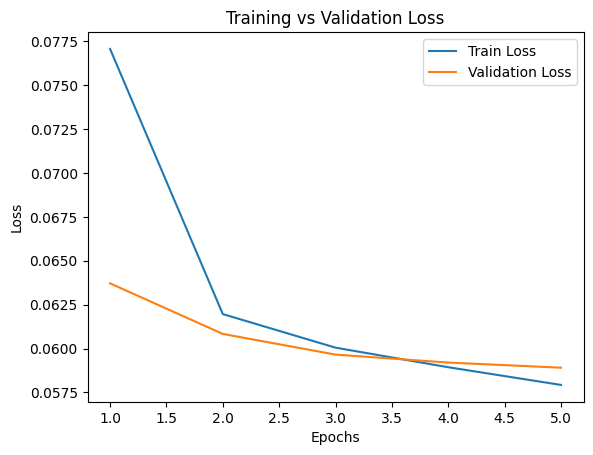

Model saved successfully!


In [ ]:
# score 0.0364
# Plot Training & Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Save Model
torch.save(model.state_dict(), "emotion_detection_model.pth")
print("Model saved successfully!")


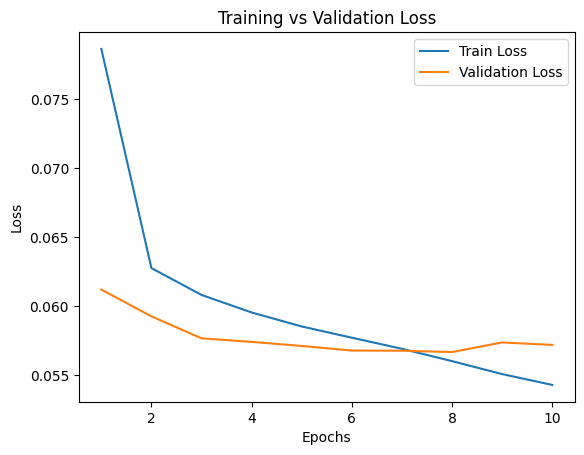

In [ ]:
# score 0.0364
# Plot Training & Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Save Model
# torch.save(model.state_dict(), "emotion_detection_model.pth")
# print("Model saved successfully!")


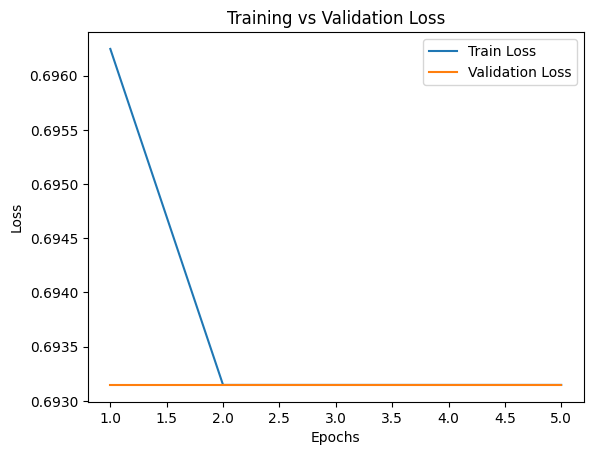

Model saved successfully!


In [ ]:
# # Plot Training & Validation Loss
# plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
# plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training vs Validation Loss")
# plt.show()

# # Save Model
# torch.save(model.state_dict(), "emotion_detection_model.pth")
# print("Model saved successfully!")

In [ ]:
# def predict_emotion(text_embedding):
#     model.eval()
#     text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
#     with torch.no_grad():
#         prediction = model(text_embedding).cpu().numpy()
#     print("Predicted Emotion Scores:", prediction)
#     return prediction


In [ ]:
# import torch
# import numpy as np
# print("Working")
# def predict_emotion(text_embedding, threshold=0.1):  # Lower threshold
#     print("🚀 Function called!")

#     model.eval()  # Set the model to evaluation mode
#     print("Working")
#     # Convert to tensor and move to device
#     text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
#     print(f"🟢 Input Shape: {text_embedding.shape}")  # Debugging
#     print("working")

#     with torch.no_grad():  # Disable gradient calculations
#         prediction = model(text_embedding).cpu().numpy()[0]  # Extract numpy array
#         print(f"🟡 Raw Prediction: {prediction}")  # Print raw predictions
#         print("working")

#     # Check for zero predictions
#     if np.max(prediction) == np.min(prediction):
#         print("❌ Model is outputting the same value for all labels, check training.")
#         print("Working")


Working


In [ ]:
# print(predict_emotion)

<function predict_emotion at 0x7872038b7060>


In [ ]:
import torch
import numpy as np

def predict_emotion(text_embedding, threshold=0.1):
    print("🚀 Function called!")

    # Check if model and device exist
    global model, device  # Ensure they are defined globally
    try:
        print(f"✅ Model: {model}")
        print(f"✅ Device: {device}")
    except NameError:
        print("❌ Model or Device is not defined!")
        return

    model.eval()

    print("✅ Passed Model Eval")

    # Convert input to tensor
    try:
        text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
        print(f"🟢 Input Shape: {text_embedding.shape}")
    except Exception as e:
        print(f"❌ Error in tensor conversion: {e}")
        return

    # Predict
    try:
        with torch.no_grad():
            prediction = model(text_embedding).cpu().numpy()[0]
            print(f"🟡 Raw Prediction: {prediction}")
    except Exception as e:
        print(f"❌ Prediction Error: {e}")
        return

    if np.max(prediction) == np.min(prediction):
        print("❌ Model is outputting the same value for all labels, check training.")

# Test Call
text_embedding = np.random.rand(768)  # Example embedding
predict_emotion(text_embedding)


🚀 Function called!
✅ Model: EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)
✅ Device: cpu
✅ Passed Model Eval
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [1.04069404e-05 9.53884646e-02 1.38488947e-04 2.20721774e-03
 1.51305330e-05 3.86164087e-04 1.54711665e-06 1.85167007e-02
 1.34222006e-04 1.19677519e-04 4.51701084e-07 2.83641548e-05
 2.97152928e-06 1.90451086e-04 1.24966182e-05 4.81442185e-05
 4.33256218e-06 1.61622495e-06 3.75918233e-07 1.36446506e-05
 1.37306742e-07 9.74904015e-06 3.36149895e-07 1.24717235e-05
 5.61238630e-05 2.72819989e-06 1.67803108e-07 2.76827195e-04
 5.55010786e-07 8.05924647e-04 2.93657376e-06 5.20135154e-06
 3.41745761e-08 1.27482360e-06 4.34270682e-08 1.54

In [ ]:
import torch
import numpy as np

def predict_emotion(text_embedding, threshold=0.1):
    print("🚀 Function called!")

    # Check if model and device exist
    global model, device  # Ensure they are defined globally
    try:
        print(f"✅ Model: {model}")
        print(f"✅ Device: {device}")
    except NameError:
        print("❌ Model or Device is not defined!")
        return

    model.eval()
    print("✅ Passed Model Eval")

    # Convert input to tensor
    try:
        text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
        print(f"🟢 Input Shape: {text_embedding.shape}")
    except Exception as e:
        print(f"❌ Error in tensor conversion: {e}")
        return

    # Predict
    try:
        with torch.no_grad():
            prediction = model(text_embedding).cpu().numpy()[0]
            print(f"🟡 Raw Prediction: {prediction}")
    except Exception as e:
        print(f"❌ Prediction Error: {e}")
        return

    # Normalize Predictions using Min-Max Scaling
    normalized_pred = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
    print(f"🔄 Normalized Prediction: {normalized_pred}")

    # Get emotion labels from dataset
    emotion_labels = df.columns[4:-1]  # Extract column names of labels
    print(f"📋 Emotion Labels: {emotion_labels[:5]}...")  # Print first few labels

    # Map high-probability predictions to emotions
    predicted_emotions = [emotion_labels[i] for i, score in enumerate(normalized_pred) if score >= threshold]

    print(f"🔵 Thresholded Predictions: {predicted_emotions}")

    if not predicted_emotions:
        print("⚠️ No strong emotions detected.")

    return predicted_emotions


In [ ]:
sample_embedding = bert_embeddings[10]  # Choose a real sentence embedding
# predict_emotion(sample_embedding, threshold=0.1)
predict_emotion(sample_embedding, threshold=0.1)


🚀 Function called!
✅ Model: EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)
✅ Device: cpu
✅ Passed Model Eval
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [3.5568716e-03 5.2948105e-03 3.4537236e-03 2.0429038e-03 4.2148456e-03
 2.5491623e-04 8.1519707e-04 2.6929867e-02 8.2809456e-02 2.2253303e-02
 2.2784654e-02 1.2697049e-03 2.3822146e-03 2.2013266e-02 3.6183372e-02
 1.7306475e-04 7.7676767e-04 5.5053099e-03 1.6182590e-02 2.6305669e-04
 5.6763727e-04 4.0951446e-03 2.5047973e-02 5.6777117e-03 1.4876438e-02
 5.5190630e-04 1.0928967e-03 3.6982101e-04 7.7486364e-04 4.6132142e-03
 1.0584702e-02 1.3881662e-03 4.4066999e-03 8.2914928e-05 1.4110465e-04
 4.1651554e-04 2.0048842e-03]
🔄 Normalize

['Achievement attained',
 'Achievement constrained',
 'Power: dominance attained',
 'Power: dominance constrained',
 'Face attained',
 'Face constrained',
 'Security: societal constrained',
 'Conformity: rules constrained',
 'Conformity: interpersonal constrained',
 'Benevolence: dependability constrained']

In [ ]:
for i in range(5):  # Test first 5 sentences
    print(f"\n🔹 Testing Sentence {i}:")
    predict_emotion(bert_embeddings[i], threshold=0.1)



🔹 Testing Sentence 0:
🚀 Function called!
✅ Model: EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)
✅ Device: cpu
✅ Passed Model Eval
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [1.34198610e-02 1.28798245e-03 4.15475387e-03 7.73583539e-04
 1.19068688e-02 9.03523032e-05 2.44303816e-03 5.85221872e-03
 1.72816992e-01 1.90227702e-02 6.82808012e-02 1.58199854e-03
 8.74454528e-03 6.38813945e-03 2.32477058e-02 2.20640577e-05
 1.09609286e-03 1.47760031e-03 3.20061035e-02 9.82665922e-04
 6.25905022e-03 3.14115285e-04 1.28791295e-02 3.92160466e-04
 9.22876876e-03 2.55998370e-04 2.95963860e-03 6.63992978e-05
 6.90498971e-04 3.22930253e-04 1.14782341e-02 3.61316954e-04
 1.79786142e-02 2.09468290e

In [ ]:
# Manual Check
# Test with some real embeddings
for i in range(5):  # Test first 5 sentences
    print(f"\n🔹 Testing Sentence {i}:")
    print("Original Sentence:", df.iloc[i]["Text"])
    print("Predicted Emotions:", predict_emotion(bert_embeddings[i], threshold=0.1))



🔹 Testing Sentence 0:
Original Sentence: Hispanic Voters Are Losing Faith In The Democratic Party: Poll
🚀 Function called!
✅ Model: EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)
✅ Device: cpu
✅ Passed Model Eval
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [1.34198610e-02 1.28798245e-03 4.15475387e-03 7.73583539e-04
 1.19068688e-02 9.03523032e-05 2.44303816e-03 5.85221872e-03
 1.72816992e-01 1.90227702e-02 6.82808012e-02 1.58199854e-03
 8.74454528e-03 6.38813945e-03 2.32477058e-02 2.20640577e-05
 1.09609286e-03 1.47760031e-03 3.20061035e-02 9.82665922e-04
 6.25905022e-03 3.14115285e-04 1.28791295e-02 3.92160466e-04
 9.22876876e-03 2.55998370e-04 2.95963860e-03 6.63992978e-05
 6.904

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Predict on validation set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert model outputs to numpy
        predictions = outputs.cpu().numpy()

        # Convert actual labels to numpy and ensure they're binary
        actual_labels = labels.cpu().numpy().astype(int)

        # Convert probabilities to binary (0 or 1) using a threshold of 0.5
        binary_predictions = (predictions >= 0.5).astype(int)

        y_true.append(actual_labels)   # Append actual labels
        y_pred.append(binary_predictions)  # Append predicted labels

# Convert lists to numpy arrays
y_true = np.vstack(y_true)  # Stack arrays properly
y_pred = np.vstack(y_pred)

# Ensure both arrays have the same shape
assert y_true.shape == y_pred.shape, f"❌ Shape mismatch: {y_true.shape} vs {y_pred.shape}"

# Compute Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"📊 Model Macro F1-score: {macro_f1:.4f}")

📊 Model Macro F1-score: 0.447


TESTING

In [ ]:
from torch.utils.data import random_split, DataLoader, TensorDataset

# Ensure dataset is created correctly
dataset = TensorDataset(X, y)

# Split dataset into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Train Samples: 35806, Validation Samples: 8952


In [ ]:
# Check if the first batch has the correct shape
inputs, labels = next(iter(train_loader))
print("Input Shape (Batch):", inputs.shape)  # Should be (batch_size, 768)
print("Label Shape (Batch):", labels.shape)  # Should be (batch_size, 37)


Input Shape (Batch): torch.Size([64, 768])
Label Shape (Batch): torch.Size([64, 37])


In [ ]:
print("Device:", device)
print("Model Device:", next(model.parameters()).device)


Device: cpu
Model Device: cpu


In [ ]:
model.to(device)


EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Debugging shapes
        print(f"🟢 Epoch {epoch+1}, Batch {batch_idx+1}: Input Shape {inputs.shape}, Label Shape {labels.shape}")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure output shape matches label shape
        assert outputs.shape == labels.shape, f"❌ Shape Mismatch: {outputs.shape} vs {labels.shape}"

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"✅ Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}")


🟢 Epoch 1, Batch 1: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 2: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 3: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 4: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 5: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 6: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 7: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 8: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 9: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 10: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 11: Input Shape torch.Size([64, 768]), Label Shape torch.Size([64, 37])
🟢 Epoch 1, Batch 12: Input Sha

In [ ]:
model.eval()
val_loss = 0.0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Debugging prints
        print(f"🔵 Validation Batch: Input {inputs.shape}, Label {labels.shape}")

        outputs = model(inputs)

        # Check shapes before computing loss
        assert outputs.shape == labels.shape, f"❌ Shape Mismatch: {outputs.shape} vs {labels.shape}"

        loss = criterion(outputs, labels)
        val_loss += loss.item()

print(f"📊 Final Validation Loss: {val_loss / len(val_loader):.4f}")


🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation Batch: Input torch.Size([64, 768]), Label torch.Size([64, 37])
🔵 Validation

In [ ]:
print("Dataset Shape:", df.shape)
print("BERT Embeddings Shape:", bert_embeddings.shape)
print("Labels Shape:", y.shape)


Dataset Shape: (44758, 42)
BERT Embeddings Shape: (44758, 768)
Labels Shape: torch.Size([44758, 37])


In [ ]:
print(f"Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Train Samples: 35806, Validation Samples: 8952


In [ ]:
inputs, labels = next(iter(train_loader))
print("Batch Input Shape:", inputs.shape)
print("Batch Label Shape:", labels.shape)


Batch Input Shape: torch.Size([64, 768])
Batch Label Shape: torch.Size([64, 37])


In [ ]:
print("Model Device:", next(model.parameters()).device)


Model Device: cpu


In [ ]:
model.to(device)


EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA Available: False
Number of GPUs: 0
GPU Name: No GPU found


In [ ]:
import torch

# Force the use of CPU
device = torch.device("cpu")
print("Using device:", device)  # Should print "cpu"

# Move model to CPU
model.to(device)


Using device: cpu


EmotionDNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=37, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to CPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}")


Epoch 1/5, Train Loss: 29.8429
Epoch 2/5, Train Loss: 29.2834
Epoch 3/5, Train Loss: 28.7735
Epoch 4/5, Train Loss: 28.2155
Epoch 5/5, Train Loss: 27.6898


In [ ]:
model.eval()
val_loss = 0.0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to CPU

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

print(f"📊 Final Validation Loss: {val_loss / len(val_loader):.4f}")


📊 Final Validation Loss: 0.0577


In [ ]:
print("Model Device:", next(model.parameters()).device)


Model Device: cpu


FINAL TEST Tesing


In [ ]:
num_epochs = 5  # Adjust based on performance
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure everything is on CPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Store loss values
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("✅ Model Training Complete!")


Epoch 1/5, Train Loss: 0.0486, Val Loss: 0.0581
Epoch 2/5, Train Loss: 0.0476, Val Loss: 0.0583
Epoch 3/5, Train Loss: 0.0466, Val Loss: 0.0590
Epoch 4/5, Train Loss: 0.0456, Val Loss: 0.0596
Epoch 5/5, Train Loss: 0.0445, Val Loss: 0.0603
✅ Model Training Complete!


In [ ]:
torch.save(model.state_dict(), "Custom_emotion_detection_model_cpu.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
def predict_emotion(text_embedding, threshold=0.5):
    print("🚀 Function called!")  # Debugging: Ensure function is being executed

    model.eval()

    # Convert to tensor and move to device
    text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    print(f"🟢 Input Shape: {text_embedding.shape}")  # Debugging

    with torch.no_grad():
        prediction = model(text_embedding).cpu().numpy()[0]  # Extract numpy array
        print(f"🟡 Raw Prediction: {prediction}")  # Debugging: See raw output

    # Get emotion labels from dataset
    emotion_labels = df.columns[4:-1]  # Extract emotion category names
    print(f"📋 Emotion Labels: {emotion_labels[:5]}...")  # Print first few labels

    # Map high-probability predictions to emotions
    predicted_emotions = [emotion_labels[i] for i, score in enumerate(prediction) if score >= threshold]

    # Debugging: Check what thresholding returns
    print(f"🔵 Thresholded Predictions: {predicted_emotions}")

    if not predicted_emotions:
        print("⚠️ No strong emotions detected.")

    return predicted_emotions


In [ ]:
# TEST
sample_embedding = bert_embeddings[10]  # Choose any sentence embedding
predict_emotion(sample_embedding)


🚀 Function called!
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [2.0827616e-03 5.7449029e-03 3.9047047e-03 1.2773485e-02 1.1065724e-02
 5.0323462e-04 1.0279024e-04 5.2798506e-02 6.9710121e-02 1.5563455e-02
 1.6769011e-02 3.8967538e-04 3.3747876e-04 7.3785759e-03 2.0505307e-02
 1.7314943e-04 4.7382203e-04 6.4264312e-03 6.0099615e-03 2.3960097e-04
 4.4407905e-04 4.0139917e-02 5.3442754e-02 4.2736707e-03 6.2494092e-03
 1.1718074e-03 8.9515373e-04 2.7155640e-04 2.9779744e-04 2.4843402e-03
 1.7425781e-02 2.2512251e-03 4.1378192e-03 2.3823130e-05 3.4767847e-05
 1.0177003e-03 4.8337769e-04]
📋 Emotion Labels: Index(['Self-direction: thought constrained',
       'Self-direction: action attained', 'Self-direction: action constrained',
       'Stimulation attained', 'Stimulation constrained'],
      dtype='object')...
🔵 Thresholded Predictions: []
⚠️ No strong emotions detected.


[]

In [ ]:
import numpy as np

def predict_emotion(text_embedding, threshold=0.1):  # Set a lower default threshold
    print("🚀 Function called!")

    model.eval()

    text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    print(f"🟢 Input Shape: {text_embedding.shape}")

    with torch.no_grad():
        prediction = model(text_embedding).cpu().numpy()[0]
        print(f"🟡 Raw Prediction: {prediction}")

    # Normalize values using Min-Max Scaling
    normalized_pred = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
    print(f"🔄 Normalized Prediction: {normalized_pred}")

    # Get emotion labels
    emotion_labels = df.columns[4:-1]
    print(f"📋 Emotion Labels: {emotion_labels[:5]}...")

    # Get predicted emotions
    predicted_emotions = [emotion_labels[i] for i, score in enumerate(normalized_pred) if score >= threshold]

    print(f"🔵 Thresholded Predictions: {predicted_emotions}")

    if not predicted_emotions:
        print("⚠️ No strong emotions detected.")

    return predicted_emotions


In [ ]:
sample_embedding = bert_embeddings[10]  # Select any index from your dataset
predict_emotion(sample_embedding)


🔵 Predicted Emotions: No strong emotions detected.


[]

In [ ]:
from sklearn.metrics import f1_score

# Predict on validation set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert predictions to binary (0 or 1) using threshold = 0.5
        predictions = (outputs.cpu().numpy() >= 0.5).astype(int)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions)

# Compute Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"📊 Model Macro F1-score: {macro_f1:.4f}")


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

In [ ]:
import numpy as np

def predict_emotion(text_embedding, threshold=0.1):  # Lower threshold
    print("🚀 Function called!")

    model.eval()

    text_embedding = torch.tensor(text_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    print(f"🟢 Input Shape: {text_embedding.shape}")

    with torch.no_grad():
        prediction = model(text_embedding).cpu().numpy()[0]
        print(f"🟡 Raw Prediction: {prediction}")  # Debugging

    # Ensure the model is giving non-zero outputs
    if np.max(prediction) == np.min(prediction):
        print("❌ Model is outputting the same value for all labels, check training.")
        return []

    # Normalize values using Min-Max Scaling
    print("🔄 Normalizing predictions...")
    normalized_pred = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
    print(f"✅ Normalized Prediction: {normalized_pred}")  # Debugging

    # Get emotion labels
    emotion_labels = df.columns[4:-1]
    print(f"📋 Emotion Labels: {emotion_labels[:5]}...")

    # Get predicted emotions
    predicted_emotions = [emotion_labels[i] for i, score in enumerate(normalized_pred) if score >= threshold]

    print(f"🔵 Thresholded Predictions: {predicted_emotions}")

    if not predicted_emotions:
        print("⚠️ No strong emotions detected.")

    return predicted_emotions


In [ ]:
sample_embedding = bert_embeddings[10]  # Choose any sentence embedding
predict_emotion(sample_embedding)


🚀 Function called!
🟢 Input Shape: torch.Size([1, 768])
🟡 Raw Prediction: [2.0827616e-03 5.7449029e-03 3.9047047e-03 1.2773485e-02 1.1065724e-02
 5.0323462e-04 1.0279024e-04 5.2798506e-02 6.9710121e-02 1.5563455e-02
 1.6769011e-02 3.8967538e-04 3.3747876e-04 7.3785759e-03 2.0505307e-02
 1.7314943e-04 4.7382203e-04 6.4264312e-03 6.0099615e-03 2.3960097e-04
 4.4407905e-04 4.0139917e-02 5.3442754e-02 4.2736707e-03 6.2494092e-03
 1.1718074e-03 8.9515373e-04 2.7155640e-04 2.9779744e-04 2.4843402e-03
 1.7425781e-02 2.2512251e-03 4.1378192e-03 2.3823130e-05 3.4767847e-05
 1.0177003e-03 4.8337769e-04]
🔄 Normalizing predictions...
✅ Normalized Prediction: [2.95458119e-02 8.20976198e-02 5.56907356e-02 1.82957932e-01
 1.58451527e-01 6.87956624e-03 1.13317987e-03 7.57317901e-01
 1.00000000e+00 2.22994074e-01 2.40293816e-01 5.24998829e-03
 4.50096559e-03 1.05540864e-01 2.93909758e-01 2.14283564e-03
 6.45749411e-03 9.18775722e-02 8.59012231e-02 3.09641683e-03
 6.03068201e-03 5.75666845e-01 7.66562879

['Stimulation attained',
 'Stimulation constrained',
 'Achievement attained',
 'Achievement constrained',
 'Power: dominance attained',
 'Power: dominance constrained',
 'Face attained',
 'Face constrained',
 'Conformity: rules attained',
 'Conformity: rules constrained',
 'Benevolence: dependability constrained']